In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Read the csv file for QMOF dataset
df = pd.read_csv('../../data/QMOF/qmof_database/qmof_database/qmof.csv', sep=',')

/var/folders/wv/fr4yw5nn3qzctb27hyfl7fzh0000gn/T/ipykernel_18598/2948253664.py:2: DtypeWarning: Columns (40,41,43,44,45,46,47,49,50,51,52,53,55,56,57,65,66,67,68,69,77,78,79,80,81,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/QMOF/qmof_database/qmof_database/qmof.csv', sep=',')


## EDA: each MOF at each level of theory taken to be an independent data point

### reorganizing the dataset
... into a new dataframe with up to four rows per MOF with one set of DFT inputs and outputs per row

In [70]:
# start by decomposing column names
info_column_names = df.columns[0:22].tolist()
dft_levels = ['pbe', 'hle17', 'hse06_10hf', 'hse06']
dft_inputs = [col.split('.')[-1] for col in df.columns[22:28]]
dft_outputs = [col.split('.')[-1] for col in df.columns[28:40]]

#  All columns are given by info_columns_names and all combinations of {'input.', 'output.'} + <dft level> + '.' + {<dft input>, <dft ouput>}?
set(df.columns) == set(
    info_column_names
    + ['inputs.' + level + '.' + i for level in dft_levels for i in dft_inputs]
    + ['outputs.' + level + '.' + i for level in dft_levels for i in dft_outputs]
)

True

In [125]:
# define a function that drops the DFT level of theory part of the inputs/ouputs column names, leaving other (info) column names untouched
def drop_level_from_column_name(col):
    if col.startswith('inputs') or col. startswith('outputs'):
        return '.'.join(col.split('.')[::2])
    else:
        return col

# stack four copies of the data frame, one for each level of theory. Then drop any rows that came from missing levels of theory.
df_by_level = pd.concat([
    # for each MOF and each level of theory, extract info columns for that MOF and inputs/outputs columns for that level. Rename inputs/outputs columns.
    df[
        info_column_names
        + ['inputs.' + level + '.' + i for i in dft_inputs]
        + ['outputs.' + level + '.' + o for o in dft_outputs]
    ].rename(mapper = drop_level_from_column_name, axis=1)
    for level in dft_levels
]).dropna(
    subset = ['inputs.' + i for i in dft_inputs] + ['outputs.' + o for o in dft_outputs]
)

# remove irrelevant columns based on domain knowledge.
df_by_level.drop([
    'name', 'info.formula', 'info.formula_reduced', 'info.mofid.mofid', 'info.mofid.mofkey', 'info.mofid.topology', 'info.symmetry.spacegroup',
    'info.symmetry.spacegroup_number', 'info.symmetry.spacegroup_crystal', 'info.symmetry.pointgroup', 'info.synthesized', 'info.source', 'info.doi',
    'inputs.pseudopotentials', 'inputs.encut', 'inputs.kpoints','inputs.gamma'
], axis=1, inplace=True)

# Note: I kept the inputs.theory column as a potential feature, since the information about which level of theory data came from
# is otherwise lost in the above procedure.
df_by_level['inputs.theory'].unique()

array(['PBE-D3BJ', 'HLE17//PBE-D3BJ', 'HSE06-D3BJ-HF10//PBE-D3BJ',
       'HSE06-D3BJ//PBE-D3BJ'], dtype=object)

In [130]:
# relabel levels of theory in those the entries to make them more readable and match the paper:
df_by_level.replace(to_replace = {'PBE-D3BJ': 'PBE', 'HLE17//PBE-D3BJ': 'HLE17', 'HSE06-D3BJ-HF10//PBE-D3BJ': 'HSE06*',
       'HSE06-D3BJ//PBE-D3BJ': 'HSE06'}, inplace = True)
df_by_level

qmof_id info.mofid.smiles_nodes  \
0      qmof-8a95c27   ['O', '[Ba]', '[Cu]']   
1      qmof-019ba28                     NaN   
2      qmof-830ed1c                ['[Co]']   
3      qmof-5bd4a24                ['[Co]']   
4      qmof-644aab4            ['[Zn][Zn]']   
...             ...                     ...   
15951  qmof-f73a75b                ['[Fe]']   
15954  qmof-600a106                     NaN   
15955  qmof-64eac3c                     NaN   
15959  qmof-92305e2      ['[OH2][Nd][OH2]']   
15961  qmof-55d409b                ['[Cu]']   

                               info.mofid.smiles_linkers  \
0                                            ['[O-]C=O']   
1                                                    NaN   
2                                  ['[O-]C(=O)c1ccncc1']   
3                                  ['[O-]C(=O)c1ccncc1']   
4      ['[O-]C(=O)c1cccc(c1)c1nccs1', 'n1ccc(cc1)c1cc...   
...                                                  ...   
15951                   ['n1ccc(cc1)c1ccc(cc1)c1ccncc1']   
15954                                                NaN   
15955                                                NaN   
15959                    ['[O-]C(=O)Cn1nnc(n1)c1cccnc1']   
15961           ['Cc1nc2c(n1CCCCn1c(C)nc3c1cccc3)cccc2']   

                                       info.mofid.smiles  info.natoms  \
0                                    O.[Ba].[Cu].[O-]C=O           39   
1                                                    NaN          128   
2                                 [Co].[O-]C(=O)c1ccncc1          108   
3                                 [Co].[O-]C(=O)c1ccncc1          108   
4      [O-]C(=O)c1cccc(c1)c1nccs1.[Zn][Zn].n1ccc(cc1)...          102   
...                                                  ...          ...   
15951                  [Fe].n1ccc(cc1)c1ccc(cc1)c1ccncc1           67   
15954                                                NaN           66   
15955                                                NaN           74   
15959         [O-]C(=O)Cn1nnc(n1)c1cccnc1.[OH2][Nd][OH2]          100   
15961          Cc1nc2c(n1CCCCn1c(C)nc3c1cccc3)cccc2.[Cu]           83   

       info.pld  info.lcd  info.density  info.volume inputs.theory  ...  \
0       0.68822   1.35480      2.763246   408.857471           PBE  ...   
1       1.18570   2.13507      3.229952  1781.965032           PBE  ...   
2       2.36128   4.21176      1.557644  1292.643180           PBE  ...   
3       2.14542   3.27957      1.616139  1245.856916           PBE  ...   
4       1.33452   2.03948      1.596537  1148.155557           PBE  ...   
...         ...       ...           ...          ...           ...  ...   
15951   1.18551   2.89246      1.495041   707.036341         HSE06  ...   
15954   1.37328   2.56785      1.711368   786.642474         HSE06  ...   
15955   1.12322   2.17481      1.692097   755.001744         HSE06  ...   
15959   1.01659   1.93464      1.892463  1095.155492         HSE06  ...   
15961   1.28465   1.95192      1.420981   799.593592         HSE06  ...   

       outputs.energy_elec  outputs.net_magmom  outputs.bandgap  outputs.cbm  \
0              -235.272007                 1.0         0.632527     1.237645   
1              -656.065494                 0.0         1.134232     3.430440   
2              -751.387618                12.0         0.345448     1.091140   
3              -751.263482                12.0         0.342645     1.308492   
4              -691.920725                 0.0         1.973007     1.855009   
...                    ...                 ...              ...          ...   
15951          -536.320647                 0.0         2.518369     2.654818   
15954          -524.633244                 0.0         2.149613     1.953162   
15955          -574.486836                 0.0         3.956167     2.750360   
15959          -807.094882                 0.0         4.557899     3.212936   
15961          -625.186032                 1.0         3.713703     

In [175]:
df_by_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52754 entries, 0 to 15961
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   qmof_id                    52754 non-null  object 
 1   info.mofid.smiles_nodes    44124 non-null  object 
 2   info.mofid.smiles_linkers  43699 non-null  object 
 3   info.mofid.smiles          44124 non-null  object 
 4   info.natoms                52754 non-null  int64  
 5   info.pld                   52754 non-null  float64
 6   info.lcd                   52754 non-null  float64
 7   info.density               52754 non-null  float64
 8   info.volume                52754 non-null  float64
 9   inputs.theory              52754 non-null  object 
 10  inputs.spin                52754 non-null  bool   
 11  outputs.energy_total       52754 non-null  float64
 12  outputs.energy_vdw         52754 non-null  float64
 13  outputs.energy_elec        52754 non-null  float64


In [202]:
numerical_columns = [
    'info.natoms', 'info.pld', 'info.lcd', 'info.density', 'info.volume',
    'outputs.energy_total','outputs.energy_vdw','outputs.energy_elec','outputs.net_magmom','outputs.bandgap','outputs.cbm','outputs.vbm'
]

### exploration of numerical data
#### (roughly) reproduced Figure 1 from the '22 QMOF paper (Rosen, et. al.)

<Axes: xlabel='inputs.theory', ylabel='outputs.bandgap'>

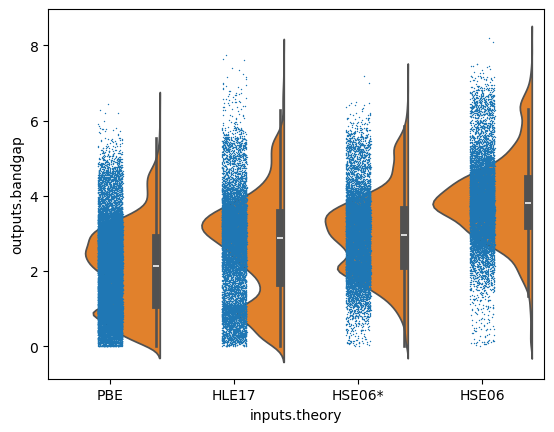

In [203]:
sns.stripplot(
    data = df_by_level, y = 'outputs.bandgap',x = 'inputs.theory',
    size = 1, dodge = True
)
sns.violinplot(
    data = df_by_level, y = 'outputs.bandgap', x = 'inputs.theory',
    split = True
)

#### Pair plots of bandgap vs. numerical data:

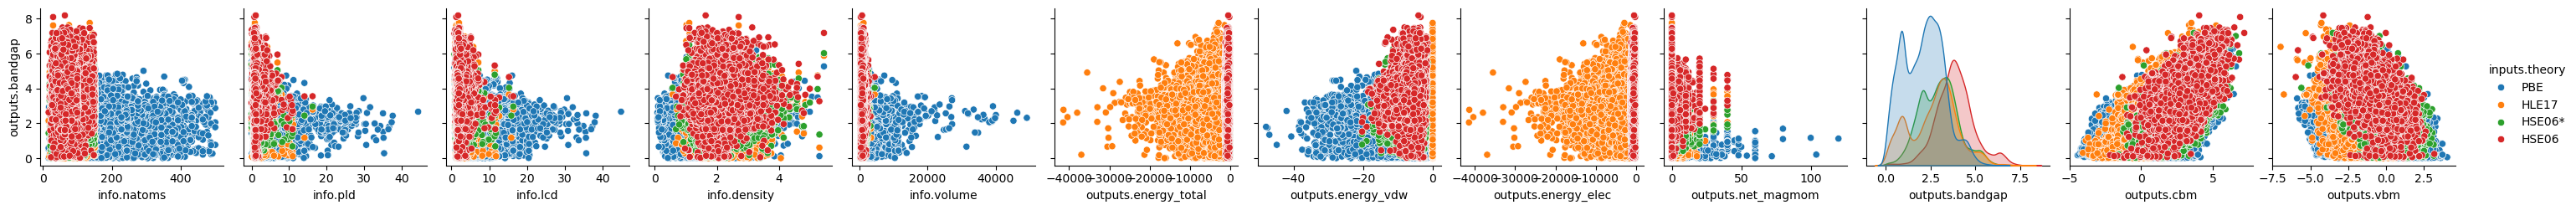

In [188]:
sns.pairplot(df_by_level, y_vars = ['outputs.bandgap'], x_vars = numerical_columns, hue = 'inputs.theory')

It looks like DFT was only done at higher levels of theory for the smaller MOFs (at most 150 atoms):

In [214]:
df_by_level.groupby('inputs.theory')['info.natoms'].max()

inputs.theory
HLE17     150
HSE06     150
HSE06*    150
PBE       500
Name: info.natoms, dtype: int64

Would this be considered a form of bias for the data coming from the higher levels of theory? There does seem to be correlation between the other numerical data and number of atoms, some very much expected, like a positive correlation between number of atoms and volume. But, in most cases, the range of possible correlations seems to be well-represented by the smaller MOFs. E.g. the ratio of pld (whatever that is) to number of atoms seems to span roughly the same range for smaller MOFs and bigger ones.

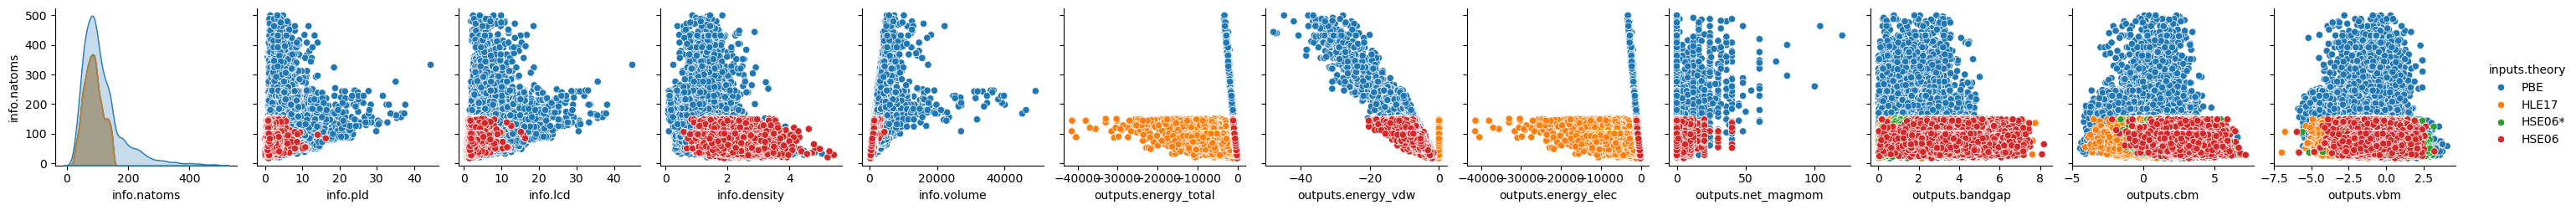

In [268]:
sns.pairplot(df_by_level, y_vars = ['info.natoms'], x_vars = numerical_columns, hue = 'inputs.theory')

#### a formulaic relationship - bandgap, CBM and VBM:

Going back to the main targert variable for now: __outputs.bandgap__ has the most apparant linear trend against __outputs.cmb__ and __outputs.vbm__. But that is for a very good (or bad, depending on your prespective) reason! Per the '22 QMOF paper (p. 7, top of second column), for "closed-shell" materials, the band gap is defined to be the difference between the conduction band minimum (CBM) and the valence band maximum (VBM). With the exception of one outlier, that is true for all data here:

<Axes: xlabel='inputs.theory', ylabel='None'>

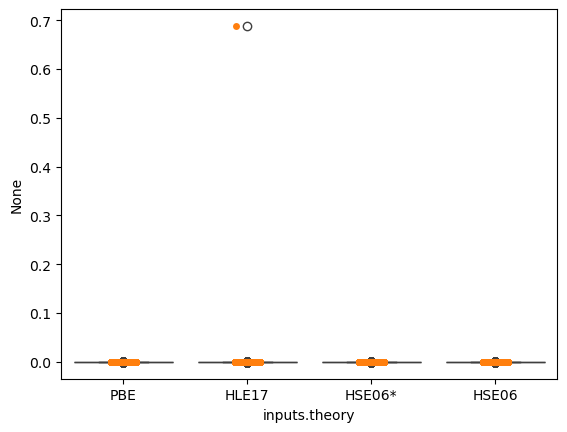

In [254]:
sns.boxplot(y = df_by_level['outputs.bandgap'] - (df_by_level['outputs.cbm']-df_by_level['outputs.vbm']), x = df_by_level['inputs.theory'] )
sns.stripplot(y = df_by_level['outputs.bandgap'] - (df_by_level['outputs.cbm']-df_by_level['outputs.vbm']), x = df_by_level['inputs.theory'] )

Also from the paper, "open-shell" / "spin-polarized" (not clear to me: are these terms equivalent, or is one a subclass of the other?) materials have two values for each CBM and VBM, one for spin-up and one for spin-down. One definition of the bandgap is then the minimum of two CMB values minus the maximum of the two VBM values. The spin-up and spin-down versions of each variable seem to be recorded under __outputs.cbm_spins__ and __outputs.vbm_spins__. It looks like the authors dediced in these cases to record the minimum CMB in __outputs.cbm__ and the maximum VBM in __outputs.cbm__:

In [351]:
df_spin_polarized = df_by_level[df_by_level['outputs.vbm_spins'] != '[None, None]']
print([
    # maximum difference (across rows) between cbm and the minimum of the two values in cmb_spins
    max([
        abs(row['outputs.cbm'] - min(eval(row['outputs.cbm_spins'])))
        for (i, row) in df_spin_polarized.iterrows()
    ]),
    # maximum difference (across rows) between vbm and the maximum of the two values in vmb_spins
    max([
        abs(row['outputs.vbm'] - max(eval(row['outputs.vbm_spins'])))
        for (i, row) in df_spin_polarized.iterrows()
    ])
]) # both should be 0.0

[0.0, 0.0]


So it is still consistent to define bandgap = CBM - VBM, as is reflected in the above plot, which shows that this definition holds for all (even the open-shell) systems. Note: the authors discuss an alternative definition of band gap for spin-polarized systems around Figure 4 in their SI. The alternative definition is related to the values in __outputs.bandgap_spins__. The spin-up value in __outputs.bandgap_spins__ is the difference between the spin-up CBM and spin-up VBM and simiarly for the spin-down value:

In [365]:
max([
    np.linalg.norm(np.array(eval(row['outputs.bandgap_spins'])) - (np.array(eval(row['outputs.cbm_spins'])) - np.array(eval(row['outputs.vbm_spins']))))
    for (i, row) in df_spin_polarized.iterrows()
]) # should be 0.0

0.0

The alternative definition of the bandgap is the minimum of the spin-up and spin-down bandgaps, which need not be the same as value from the first definition, which is in __outputs.bandgap__:

In [367]:
max([
    abs(row['outputs.bandgap'] - min(eval(row['outputs.bandgap_spins'])))
    for (i, row) in df_spin_polarized.iterrows()
    ]
   ) # is not 0.0 because of difference in definitions of band gap

1.8532559999999998

#### another formulaic relationship - energy:
Not surprising that total energy = electron (?) energy + Van der Waals energy.
__outputs.energy_total__ seems to be the sum of __outputs.energy_elec__ and __outputs.energy_vdw__ up to discretization error.

<Axes: xlabel='inputs.theory', ylabel='None'>

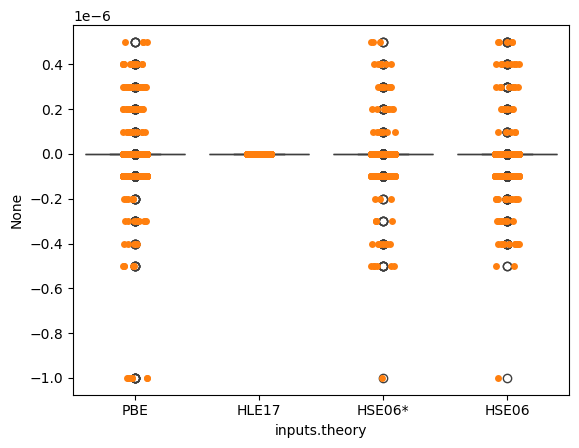

In [255]:
sns.boxplot(y = df_by_level['outputs.energy_total'] - df_by_level['outputs.energy_elec'] - df_by_level['outputs.energy_vdw'], x = df_by_level['inputs.theory'] )
sns.stripplot(y = df_by_level['outputs.energy_total'] - df_by_level['outputs.energy_elec'] - df_by_level['outputs.energy_vdw'], x = df_by_level['inputs.theory'] )

#### HLE17 and energy:
Why do the outliers not appear for HLE17? Looking at the pair plots above, HLE17 has large (in magnitude) values for total energy and electron energy relative to the other levels of theory but near 0 Van der Waals energy. Actually exactly 0 Van der Waals energy:

In [256]:
df_by_level.groupby('inputs.theory')['outputs.energy_vdw'].min()

inputs.theory
HLE17      0.00000
HSE06    -20.31142
HSE06*   -20.31142
PBE      -47.89654
Name: outputs.energy_vdw, dtype: float64

<Axes: xlabel='inputs.theory', ylabel='outputs.energy_vdw'>

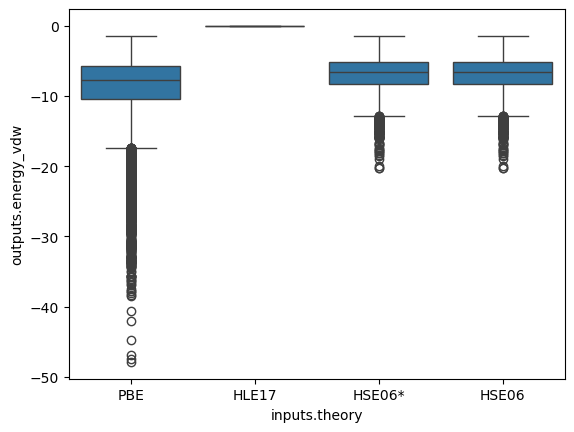

In [257]:
sns.boxplot(y = df_by_level['outputs.energy_vdw'], x = df_by_level['inputs.theory'] )

<Axes: xlabel='inputs.theory', ylabel='outputs.energy_total'>

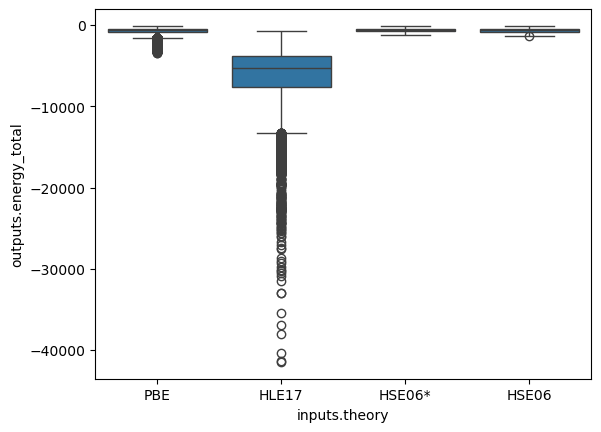

In [250]:
sns.boxplot(
    data = df_by_level, y = 'outputs.energy_total',x = 'inputs.theory'
)

What is it about the HLE17 level of theory that give these extreme values? And is it important to the band gap? Here are the energy - bandgap pair plots again, excluding the HLE17 values:

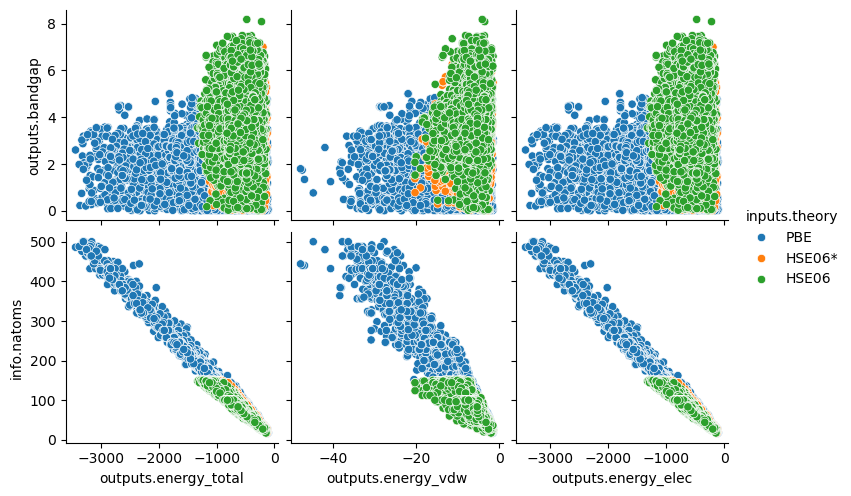

In [269]:
sns.pairplot(df_by_level[df_by_level['inputs.theory'] != "HLE17"], y_vars = ['outputs.bandgap', 'info.natoms'], x_vars = ['outputs.energy_total','outputs.energy_vdw','outputs.energy_elec'], hue = 'inputs.theory')

There doesn't seem to be a strong correlation between energy and band gap. But (not surprisingly) energy scales with number of atoms for these three levels of theory.

#### Pair plots of bandgap vs. data scaled by number of atoms:
Are any further correlations revealed if one first normalizes the "extensive" variables by number of atoms?

In [373]:
extensive_columns = ['info.pld', 'info.lcd', 'info.volume', 'outputs.energy_total', 'outputs.energy_vdw', 'outputs.energy_elec']
df_by_level_per_atom = df_by_level.copy()
for col in extensive_columns:
    df_by_level_per_atom[col] = df_by_level_per_atom[col] / df_by_level_per_atom['info.natoms']


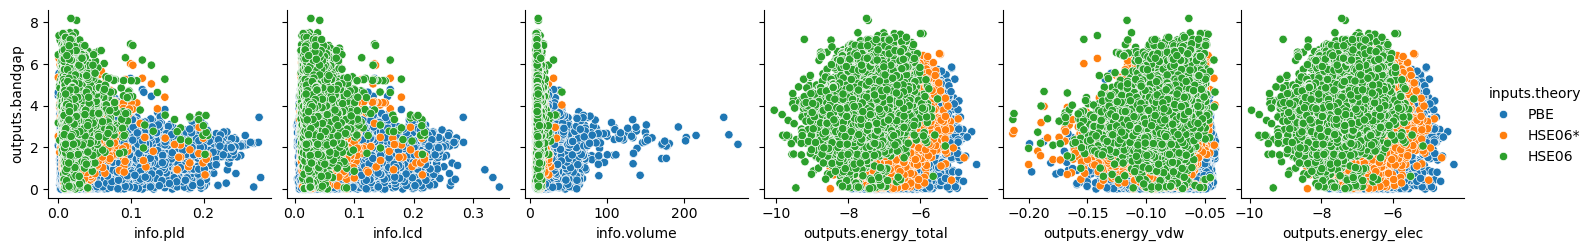

In [374]:
sns.pairplot(df_by_level_per_atom[df_by_level_per_atom['inputs.theory'] != "HLE17"], y_vars = ['outputs.bandgap'], x_vars = extensive_columns, hue = 'inputs.theory')

There doesn't seem to any strong relationships here.

### exploration of categorical data: closed- vs. open-shell
reproduced Figure 2a from the '22 QMOF paper:

In [397]:
df_by_level['is_closed_shell'] = (df_by_level['outputs.bandgap_spins'] == '[None, None]')

<Axes: xlabel='inputs.theory', ylabel='outputs.bandgap'>

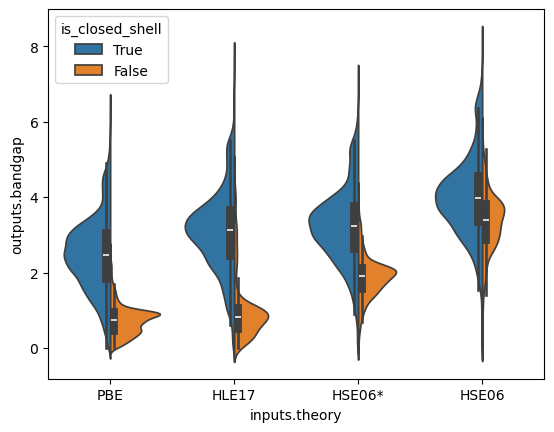

In [399]:
sns.violinplot(
    data = df_by_level, y = 'outputs.bandgap', x = 'inputs.theory',
    split = True, hue = 'is_closed_shell', hue_order = [True, False]
)

Does separating close and open reveal any realtionship between the numerical variables?

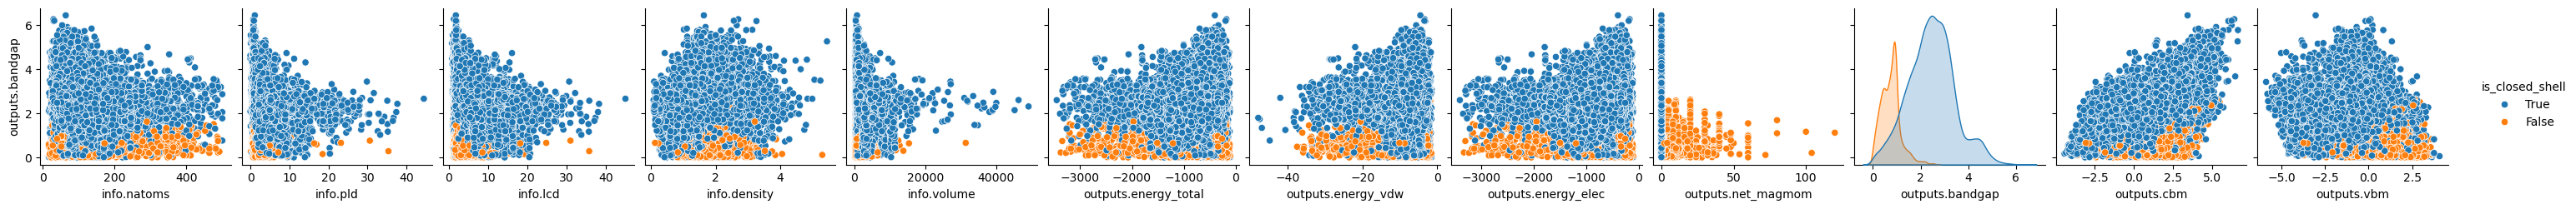

In [403]:
sns.pairplot(
    df_by_level[df_by_level['inputs.theory']=="PBE"],
    y_vars = ['outputs.bandgap'],
    x_vars = numerical_columns,
    hue = 'is_closed_shell', hue_order = [True, False]
)

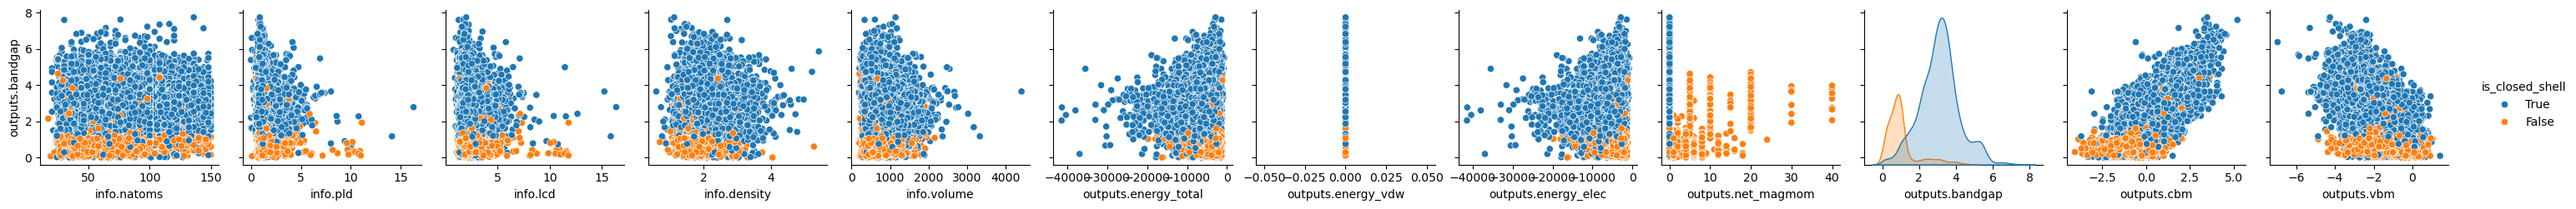

In [404]:
sns.pairplot(
    df_by_level[df_by_level['inputs.theory']=="HLE17"],
    y_vars = ['outputs.bandgap'],
    x_vars = numerical_columns,
    hue = 'is_closed_shell', hue_order = [True, False]
)

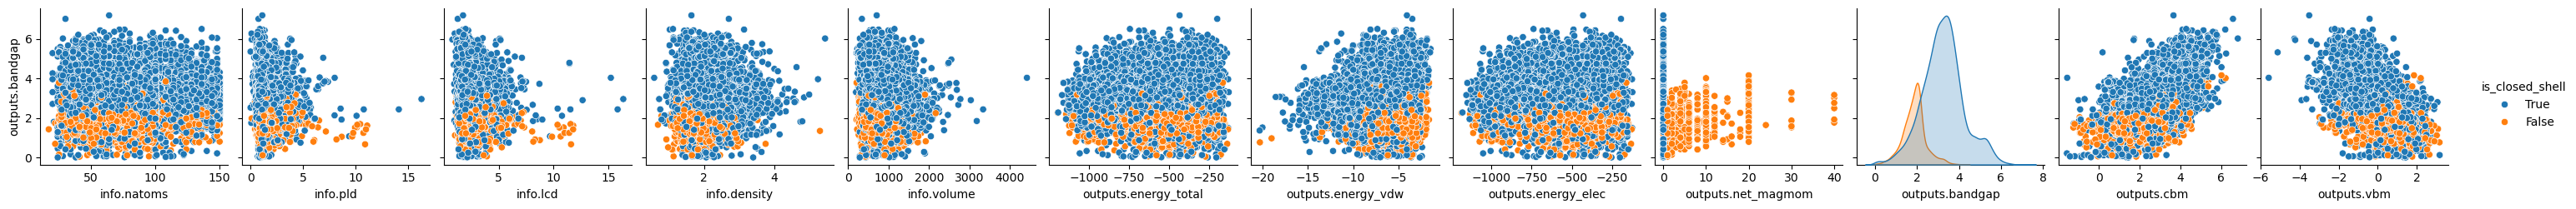

In [405]:
sns.pairplot(
    df_by_level[df_by_level['inputs.theory']=="HSE06*"],
    y_vars = ['outputs.bandgap'],
    x_vars = numerical_columns,
    hue = 'is_closed_shell', hue_order = [True, False]
)

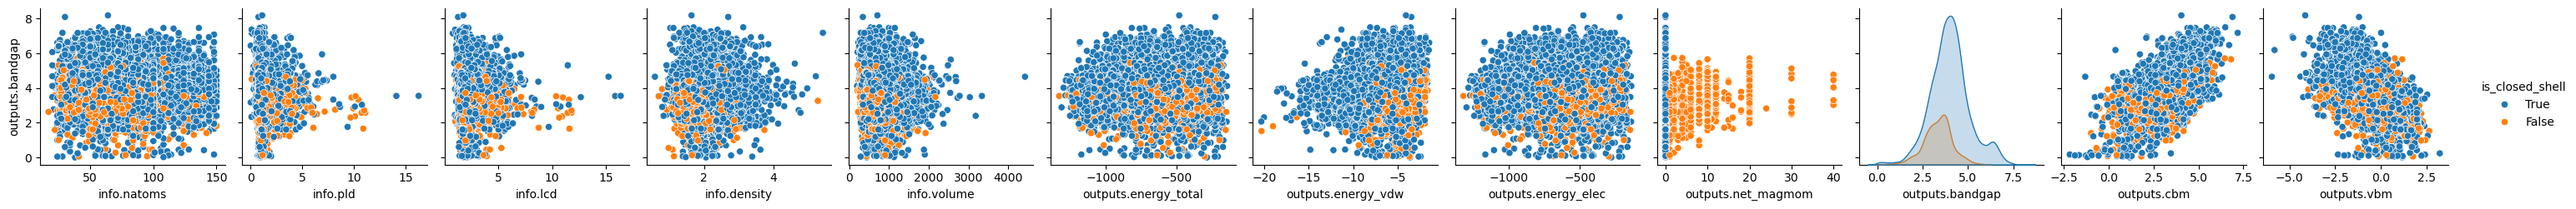

In [406]:
sns.pairplot(
    df_by_level[df_by_level['inputs.theory']=="HSE06"],
    y_vars = ['outputs.bandgap'],
    x_vars = numerical_columns,
    hue = 'is_closed_shell', hue_order = [True, False]
)

Not really - the only thing of note is, as might be expected, closed-shell systems have 0 magnetic moment:

<Axes: xlabel='is_closed_shell', ylabel='outputs.net_magmom'>

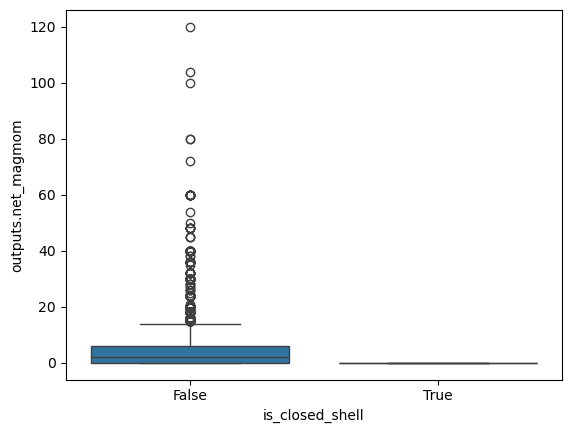

In [407]:
sns.boxplot(df_by_level, y = 'outputs.net_magmom', x = 'is_closed_shell')

## EDA: one MOF = one data point
... restricted to MOFs with all four levels of theory available

In [386]:
df_4_levels = df.copy()
df_4_levels.dropna(subset = ['inputs.' + level + '.theory' for level in dft_levels])

qmof_id        name        info.formula info.formula_reduced  \
4      qmof-644aab4  ABAXUZ_FSR     Zn2C50H32N6O8S4       ZnC25H16N3O4S2   
13     qmof-85a8986  ABEWUB_FSR      Dy4C28H32N8O36           DyC7H8N2O9   
26     qmof-07d3562  ABIVOY_FSR      Ba4C32H48O44S4          BaC8H12O11S   
27     qmof-9883029  ABIWAL_FSR      Cd2C56H52N16O8         CdC28H26N8O4   
29     qmof-f224151  ABIWUF_FSR     Cd2C56H56I4N4O4       CdC28H28I2N2O2   
...             ...         ...                 ...                  ...   
15951  qmof-f73a75b  YOVGEX_FSR        FeC34H24N6S2         FeC34H24N6S2   
15954  qmof-600a106  YOVZAL_FSR      Cu4C28H20N12O2         Cu2C14H10N6O   
15955  qmof-64eac3c  YOWCOE_FSR      Zn2C30H26N2O14          ZnC15H13NO7   
15959  qmof-92305e2  YOXJIG_FSR  Nd2C32Cl2H32N20O12      NdC16ClH16N10O6   
15961  qmof-55d409b  YOYFEY_FSR        CuC36H36N4O6         CuC36H36N4O6   

                                        info.mofid.mofid  \
4                                                    NaN   
13                                                   NaN   
26                                                   NaN   
27     [Cd].n1cc([nH]c1)c1ccc(cc1)c1[nH]cnc1 MOFid-v1...   
29                                                   NaN   
...                                                  ...   
15951  [Fe].n1ccc(cc1)c1ccc(cc1)c1ccncc1 MOFid-v1.sql...   
15954                                                NaN   
15955                                                NaN   
15959                                                NaN   
15961                                                NaN   

                     info.mofid.mofkey    info.mofid.smiles_nodes  \
4                                  NaN               ['[Zn][Zn]']   
13                                 NaN  ['[OH2][Dy]([OH2])[OH2]']   
26                                 NaN              ['O', '[Ba]']   
27     Cd.POSVDPHCDPQXKI.MOFkey-v1.sql                   ['[Cd]']   
29                                 NaN                 ['I[Cd]I']   
...                                ...                        ...   
15951  Fe.MAWKLXRVKVOYLR.MOFkey-v1.sql                   ['[Fe]']   
15954                              NaN                        NaN   
15955                              NaN                        NaN   
15959                              NaN         ['[OH2][Nd][OH2]']   
15961                              NaN                   ['[Cu]']   

                               info.mofid.smiles_linkers  \
4      ['[O-]C(=O)c1cccc(c1)c1nccs1', 'n1ccc(cc1)c1cc...   
13     ['[O-]C(=O)C(=O)[O-]', '[O-]C(=O)c1ncnc(c1)C(=...   
26         ['[O-]C(=O)c1cc(cc(c1)S([O])([O])[O])C(=O)O']   
27                  ['n1cc([nH]c1)c1ccc(cc1)c1[nH]cnc1']   
29     ['COc1c(cc(c(c1c1c(C)c(C)cc(c1OC)c1ccncc1)C)C)...   
...                                                  ...   
15951                   ['n1ccc(cc1)c1ccc(cc1)c1ccncc1']   
15954                                                NaN   
15955                                                NaN   
15959                    ['[O-]C(=O)Cn1nnc(n1)c1cccnc1']   
15961           ['Cc1nc2c(n1CCCCn1c(C)nc3c1cccc3)cccc2']   

                                       info.mofid.smiles info.mofid.topology  \
4      [O-]C(=O)c1cccc(c1)c1nccs1.[Zn][Zn].n1ccc(cc1)...                 NaN   
13     [O-]C(=O)C(=O)[O-].[O-]C(=O)c1ncnc(c1)C(=O)[O-...                 NaN   
26      O.[Ba].[O-]C(=O)c1cc(cc(c1)S([O])([O])[O])C(=O)O                 NaN   
27                 [Cd].n1cc([nH]c1)c1ccc(cc1)c1[nH]cnc1                 sql   
29     COc1c(cc(c(c1c1c(C)c(C)cc(c1OC)c1ccncc1)C)C)c1...                 NaN   
...                                                  ...                 ...   
15951                  [Fe].n1ccc(cc1)c1ccc(cc1)c1ccncc1                 sql   
15954                                                NaN                 NaN   
15955                                                NaN                 NaN   
15959         [O-]C(=O)Cn1nn

### bandgap correlations across levels of theory 
... with separation of closed- and open-shell systems.
Note: the bottom three subfigures in the first column roughly reproduce Figure 3 from the '22 QMOF paper.

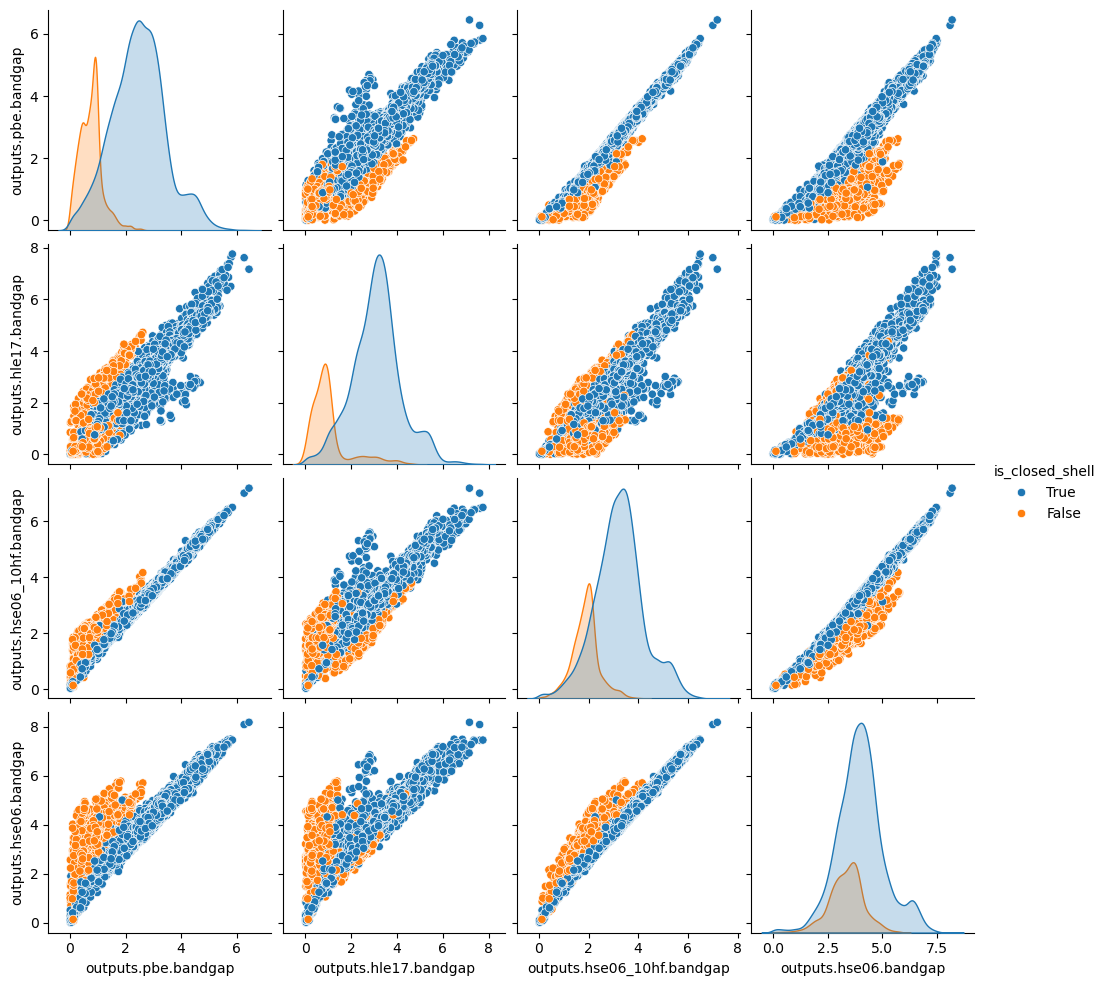

In [409]:
df_4_levels['is_closed_shell'] = (df_4_levels['outputs.pbe.bandgap_spins'] == '[None, None]')
sns.pairplot(
    df_4_levels,
    y_vars = ['outputs.' + level + '.bandgap' for level in dft_levels],
    x_vars = ['outputs.' + level + '.bandgap' for level in dft_levels],
    hue = 'is_closed_shell', hue_order = [True, False])

## additional EDA for new potential features - 'fingerprints' of the relaxed MOF structures

### Eigenvalues of the Sine Coulomb Matrix
The 'sine_matrix_fingerprints.csv' file generated from the MOF structures contains 501 columns: 1 column listing the MOF id and 500 columns to list up to 500 eigenvalues of the sine Coulomb matrix. For MOFs with matricies that have less than 500 eigenvalues, the rows are padded with 0.0's:

In [114]:
evSCM = pd.read_csv('../../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_fingerprints.csv', sep=',')
evSCM.head()

MOF  sine coulomb matrix eig 0  sine coulomb matrix eig 1  \
0  qmof-0000295                1691.427298                1560.244952   
1  qmof-00019ff                2907.030536                1364.645982   
2  qmof-0001b0d                1802.469471                1732.081967   
3  qmof-0003ae4                 139.946646                  83.478306   
4  qmof-000512e                 617.233971                 564.388755   

   sine coulomb matrix eig 2  sine coulomb matrix eig 3  \
0                 137.059900                  85.726398   
1                2521.150564                2370.534598   
2                1363.264016                 178.118907   
3                  80.230482                  75.994663   
4                 165.979086                   0.404738   

   sine coulomb matrix eig 4  sine coulomb matrix eig 5  \
0                  76.930876                  74.818457   
1                2383.323768                 179.706962   
2                  97.352536                  94.760572   
3                  74.484638                  71.567389   
4                   0.325928                  91.008065   

   sine coulomb matrix eig 6  sine coulomb matrix eig 7  \
0                  66.357818                  63.019537   
1                  93.568952                  91.120197   
2                  89.695991                  87.103939   
3                  69.691548                  68.374646   
4                  86.933901                  80.051556   

   sine coulomb matrix eig 8  ...  sine coulomb matrix eig 490  \
0                  60.947984  ...                          0.0   
1                  89.876367  ...                          0.0   
2                  83.213032  ...                          0.0   
3                  66.877563  ...                          0.0   
4                  79.421213  ...                          0.0   

   sine coulomb matrix eig 491  sine coulomb matrix eig 492  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   sine coulomb matrix eig 493  sine coulomb matrix eig 494  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   sine coulomb matrix eig 495  sine coulomb matrix eig 496  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   sine coulomb matrix eig 497  sine coulomb matrix eig 498  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   sine coulomb matrix eig 499  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  

[5 rows x 501 columns]

Note: unlike what I expected, the eigenvalues are listed only roughly, but not strictly, in order of descending magnitude. I am not sure why.

In [113]:
# For each row, calculate the maximum difference between absolute values of one eigenvalue and the next.
np.max(np.diff(np.abs(evSCM.values[:,1:]), axis=1), axis=1)
# If the eigenvalues were strictly decreasing in magnitude, all of these numbers would be negative.

array([7.25920127434452, 1156.504582288496, 13.535232515612915, ...,
       22.267113003465056, 21.268711630023084, 32.558499865839366],
      dtype=object)

#### feature engineering - (smoothed) spectral density of the sine Coulomb matrix

In the context of the pandas library and other data science tools in python, it might be natural to consider each column of the above dataframe as a potential feature: one feature would be the largest in magnitude eigenvalue, and another might be (roughly) the 10th largest.

But that seems odd to me. From a mathematical prespective, the eigenspectrum of a matrix is a (unordered) __set__, not a (ordered) list. It could be useful to consider the eigenspectrum _as a whole_ as a feature, rather than, say, the 17th largest eigenvalue. After all, it could conceivably be the case that two MOFs having similar bandgaps is correlated with the fact that both their sine Coulomb matricies have an eigenvalue around 10, even though that is the 7th largest eigenvalue for the first MOF and the 13th for the second (for example).

Therefore I consider the following representation of the eigenspectrum, which I will call the "(log-scale) smoothed spectral density" of the sine Coulomb matrix:
$$
\mathrm{SSD}(x) = \sum_{\lambda \in \Lambda\setminus{0}} f(x-\log_{10} |\lambda|),
$$
where $\Lambda\setminus{0}$ is the set of non-zero eigenvalues. There might be many valid choices for the function $f$, but in practice I will use the normal probability distribution function with mean $0$ and adjustable standard deviation $\sigma$ (to be set as a hyperparameter). The potential features that we might use to predict band gap are various aspects of the function $\mathrm{SSD}$, e.g. the values it takes on at a discrete set of $x$ values, the location of its global maximum, etc. One can also consider two normalized versions of $\mathrm{SSD}$. First $\tilde{\mathrm{SSD}}$ with the property that
$$
\int_{-\infty}^{\infty} \tilde{\mathrm{SSD}}(x) dx = 1,
$$
so that $\tilde{\mathrm{SSD}}$ can be interpreted as a probabilty density.
And $\hat{\mathrm{SSD}}$ with the property that
$$
\int_{-\infty}^{\infty} \hat{\mathrm{SSD}}(x)^2 dx = 1.
$$
This second normalized version would allow for measuring the similarlity of two MOFs by the inner product of their normalized smoothed spectral densities:
$$
\mathrm{similarity} = \int_{-\infty}^{\infty} \hat{\mathrm{SSD}}_1(x) \hat{\mathrm{SSD}}_2(x) dx,
$$
which would take on values between $-1$ and $1$.

As an example, here is a plot of $\hat{\mathrm{SSD}}$ (in black) for the first MOF listed in sine_matrix_fingerprints.csv. The short gray vertical lines mark the location of the eigenvalues.
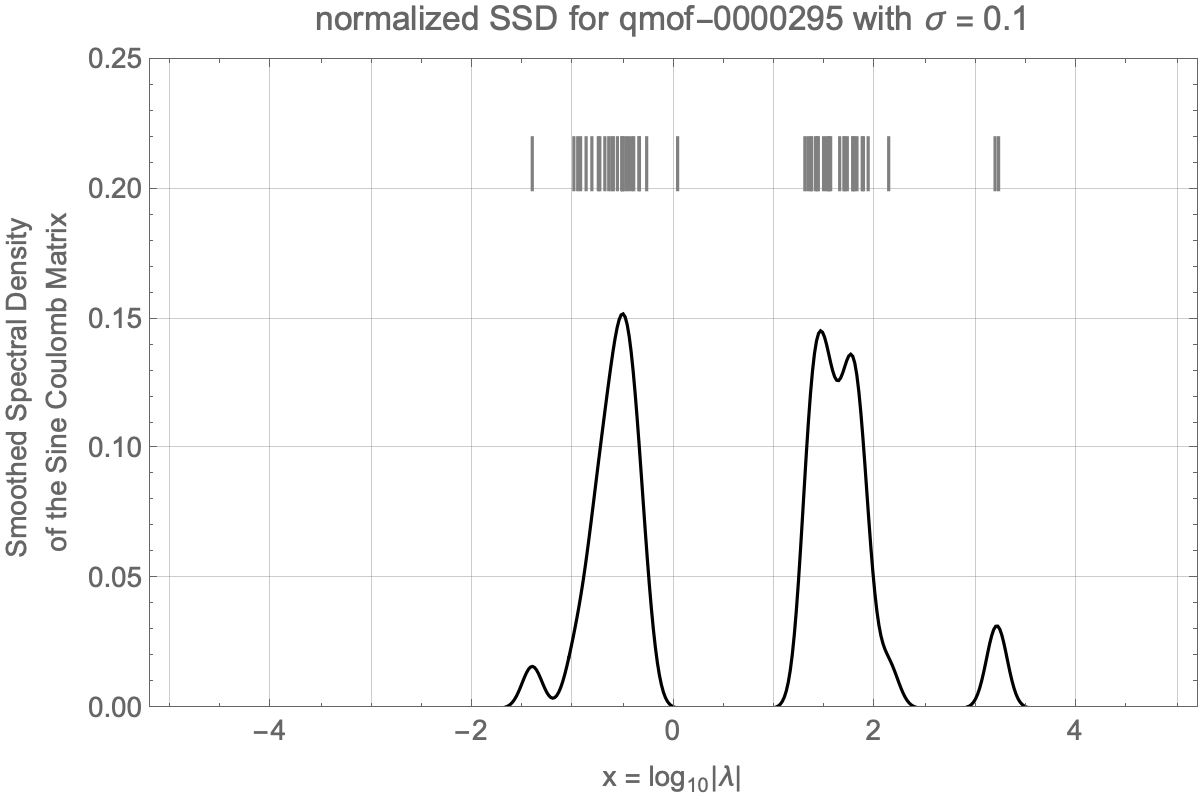

To explore the utility of the smoothed spectral density (SSD) as a feature to predict bandgap, I binned MOFs according to HSE06 band gap and then computed the average SSD across MOFs in given bin. This way I can investigate trends in the SSD as a function of band gap. Here are plots of the average SSDs for three different bins:

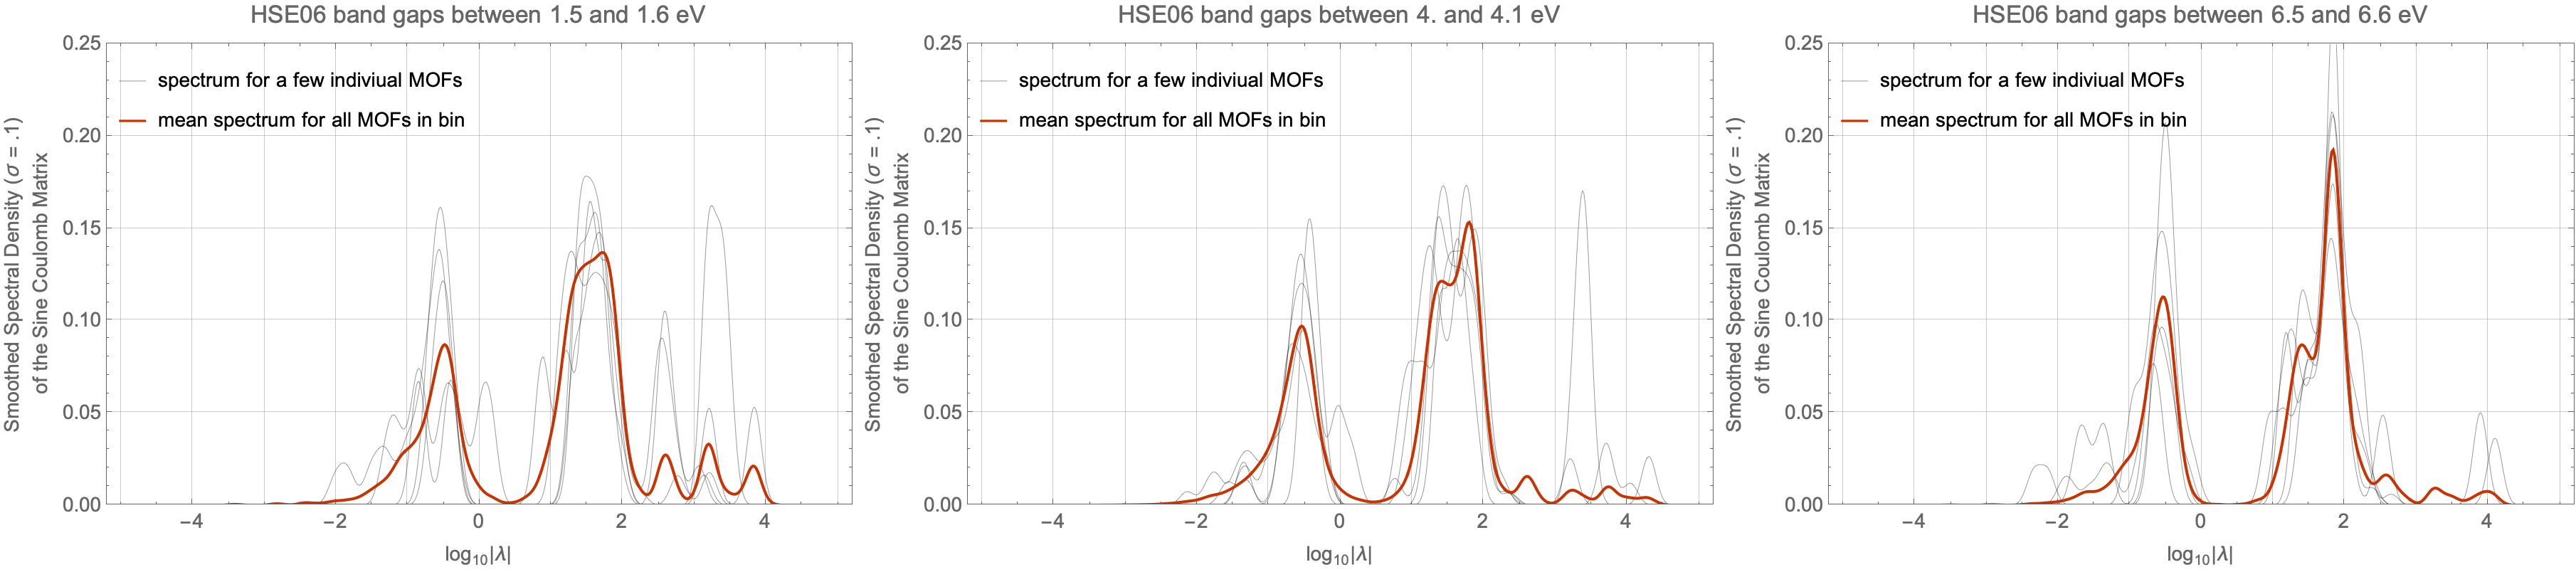

On average, there seems to be a prominent peaks around $x=-0.5$ and around $x=1.5$. As band gap increases, the height of both peaks increases on average, and the width of the second narrows. These trends can be seen more clearly in this animation across more of the band gaps bins: https://www.dropbox.com/scl/fi/e3t17jtaug6lqaorfiake/SSDAverages_acrossBandGap.mp4?rlkey=0qnrn6sx5c2dl9aiqoaqd16gh&dl=0 

Given these observations, interesting features might be the height of the SSD peaks and some measure of the width of the peak around $x=1.5$. Alternatively, one can consider using "all" values of the SSD, i.e. those at a finely sampled set of $x$ values, and possibly running PCA on those values to determine features.

Note: an alternative to introducing new features like the the SSD would be to train a model that, by its structure, is invariant under permuations of the list of eigenvalues. I.e. the model produces the same output whether it receives as inputs eigenvalues in the order $\lambda_1, \lambda_2, \lambda_3$ or another order like $\lambda_2, \lambda_1, \lambda_3$. Such "permuation-invariant" models have been considered in the literature before (see e.g. https://arxiv.org/pdf/2403.17410), but usually in the context of neural networks. What I am considering above is to engineer a set of features from the eigenvalues that are already permutation-invariant, so that the regression model need not be explictly permuation-invariant.

#### feature engineering - log-scaled smoothed density of the sine Coulomb matrix eigenvalues - 2025-03-20 update
Here I further investigate a density represenation of the eigenvalues of the sine Coulomb matrix. In contrast with my first pass at this idea above, I will consider two densities: one for positive eigenvalues ($\mathrm{SSD}_{+}$) and one for negative eigenvalues ($\mathrm{SSD}_{-}$), so that all information about the (non-zero) eigenvalues is preserved in this 'density' representation. I consider either not normalizing the densities (so that their integrals are proportional to the number of positive and negative eigenvalues, repectively) or normalize the two densities by the same factor so that the sum of their integrals are $1$. I will not consider here the second form of normalization, where the intergral of their _squares_ are $1$. From our group's discussions, it seems more likely that we will use parametric regression on the numerical values of features (perhaps determined by PCA), and either no normalization or the the first form of normalization seems best suited for that. The second form of normalization might have been more appropriate for non-parameteric regression, like some form of nearest neighbors regression, where a similarity score might have played a role.

The following generates $\mathrm{SSD}_{+}$ and $\mathrm{SSD}_{-}$ using Guassian $f$ with $\sigma = 0.1$, discretized at x values from $-5$ to $5$ in steps of $0.02$. Note: x is the log10 of the eigenvalue. That is a total of 1002 density values from at most 500 eigenvalues, so this is a redundant representation. But I anticipate using PCA to reduce down from these 1002 features.

This code generates the discretized densities for all MOFs in the QMOF database. And they are stored in a new csv file to avoid repeating this computation, which takes ~ 1 hour on my laptop.

In [274]:
num_MOFs = evSCM.shape[0]
xRange = np.arange(-5,5.02,.02)

#empty array to store density values
SSDPositive_array = np.empty((num_MOFs, len(xRange)))
SSDNegative_array = np.empty((num_MOFs, len(xRange)))

# iterate over rows
for (i, row) in evSCM.iloc[0:num_MOFs].iterrows():
    if i % 100 == 0:
        print('MOF ', i, ' out of ', num_MOFs)
    
    eigs = row[1:].astype(np.float64)
    SSDPositive_array[i] = np.round(
        [
            np.sum(np.exp(-((x - np.log10(eigs[eigs > 0]))/0.1)**2 / 2)) # add contributions from each positive eigenvalue to density at x
            for x in xRange
        ],
        decimals = 6 #round each density value to the nearest 10^-6
    )
    
    SSDNegative_array[i] = np.round(
        [
            np.sum(np.exp(-((x - np.log10(-eigs[eigs < 0]))/0.1)**2 / 2)) # add contribution from each negative eigenvalue to density at x 
            for x in xRange
        ],
        decimals = 6 #round each density value to the nearest 10^-6
    )

# convert arrays to data frames and label columns with x values
SSDPositive_df = pd.DataFrame(data = SSDPositive_array, columns = ['x = ' + ('%0.2f' % x) + ' (eigs > 0)' for x in xRange])
SSDNegative_df = pd.DataFrame(data = SSDNegative_array, columns = ['x = ' + ('%0.2f' % x) + ' (eigs < 0)' for x in xRange])

# concatenate SSDPositive and SSDNegative dataframes with the MOF id column
SSD_df = pd.concat((evSCM.iloc[0:num_MOFs][['MOF']], SSDPositive_df, SSDNegative_df), axis = 1)

# save resulting dataframe
SSD_df.to_csv('../../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_SSDs.csv', sep=',', index=False)

MOF  0  out of  20374
MOF  100  out of  20374
MOF  200  out of  20374
MOF  300  out of  20374
MOF  400  out of  20374
MOF  500  out of  20374
MOF  600  out of  20374
MOF  700  out of  20374
MOF  800  out of  20374
MOF  900  out of  20374
MOF  1000  out of  20374
MOF  1100  out of  20374
MOF  1200  out of  20374
MOF  1300  out of  20374
MOF  1400  out of  20374
MOF  1500  out of  20374
MOF  1600  out of  20374
MOF  1700  out of  20374
MOF  1800  out of  20374
MOF  1900  out of  20374
MOF  2000  out of  20374
MOF  2100  out of  20374
MOF  2200  out of  20374
MOF  2300  out of  20374
MOF  2400  out of  20374
MOF  2500  out of  20374
MOF  2600  out of  20374
MOF  2700  out of  20374
MOF  2800  out of  20374
MOF  2900  out of  20374
MOF  3000  out of  20374
MOF  3100  out of  20374
MOF  3200  out of  20374
MOF  3300  out of  20374
MOF  3400  out of  20374
MOF  3500  out of  20374
MOF  3600  out of  20374
MOF  3700  out of  20374
MOF  3800  out of  20374
MOF  3900  out of  20374
MOF  4000  o

#### feature engineering - how predictive are the density values in comparison with the list of eigenvalues?
In the following, I compare the two representations of the sine Coulomb matrix eigenspectrum: the densities and the original ordered list of eigenvalues. Restricting both feature sets to 75% of the training set of MOFs, I run PCA on both, and regress the HSE06 bandgap on the first $n$ prinicpal components with OLS linear regression. Then I compare the cross validation error (from predicting on the remaining 25% of the training set) between the two representations as a function of $n$.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

def compare_feature_sets_PCA(df, x_cols_list, y_col, num_PCs_list, train_size):

    # Split data into training and testing sets
    df_tt, df_cv = train_test_split(df, train_size = train_size)

    # empty array to store cross validation errors, number of principal components changing across rows, feature sets across columns
    cv_mse = np.empty((len(num_PCs_list)+1, len(x_cols_list)+1))
    cv_mse[:] = np.nan

    # always store the error for 0 principal components, i.e. error in predicting the cv y values by the mean of the tt y values
    cv_mse[0,0] = 0
    predicted_y = np.ones(df_cv[y_col].shape) * np.mean(df_tt[y_col])
    cv_mse[0,1:]= np.ones((1, len(x_cols_list))) * mse(df_cv[y_col], predicted_y)

    # loop over the number of principal components to use
    for (i, num_PCs) in enumerate(num_PCs_list):
            
        cv_mse[i+1,0] = num_PCs
        pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=num_PCs)), ('reg', LinearRegression())])

        # ... and over feature sets
        for (j, x_cols) in enumerate(x_cols_list):

            if len(x_cols) >= num_PCs: # If there are enough features in this feature set,
                pca_pipe.fit(df_tt[x_cols], df_tt[y_col]) # ... fit on tt set,
                predicted_y = pca_pipe.predict(df_cv[x_cols]) #  ... predict on cv set,
                cv_mse[i+1,j+1] = mse(df_cv[y_col], predicted_y) # .. and store cv error.
            
    return cv_mse

In [5]:
# load all dataframes
df_train = pd.read_csv('../../data/datasets_main/train_hse06.csv', sep=',')
df_SSD = pd.read_csv('../../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_SSDs.csv', sep=',')
df_eigs = pd.read_csv('../../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_fingerprints.csv', sep=',')

df_train_SSD_eigs = pd.merge(df_SSD, df_train, left_on='MOF', right_on='qmof_id', how='right').merge(df_eigs)

# feature set 1: list of eigenvalues
eigs_columns = ['sine coulomb matrix eig '+str(n) for n in range(0,500)]

# feature set 2: density representation
xRange = np.arange(-5,5.02,.02)
SSD_columns = ['x = ' + ('%0.2f' % x) + ' (eigs > 0)' for x in xRange] + ['x = ' + ('%0.2f' % x) + ' (eigs < 0)' for x in xRange]

In [6]:
# generate normalized versions of the densities
# (up to a common factor across all MOFs, this can be done by diving the density by the number of atoms)
df_SSD_normalized = df_train_SSD_eigs[['MOF','info.natoms'] + SSD_columns].copy()
for col in SSD_columns:
    df_SSD_normalized[col] = df_SSD_normalized[col] / df_SSD_normalized['info.natoms']
df_SSD_normalized = df_SSD_normalized.drop(columns = ['info.natoms']).rename(columns = dict(
    [
        [col, col + ' normalized']
        for col in SSD_columns
    ]
))
# add normalized density values to joint data frame
df_train_SSD_eigs = df_train_SSD_eigs.merge(df_SSD_normalized)

# feature set 3: normalized density representation
xRange = np.arange(-5,5.02,.02)
normalized_SSD_columns = [col + ' normalized' for col in SSD_columns]

In [448]:
cv_mses = compare_feature_sets_PCA(df_train_SSD_eigs, [eigs_columns, SSD_columns, normalized_SSD_columns], 'outputs.hse06.bandgap', np.arange(5,205,5), .75)

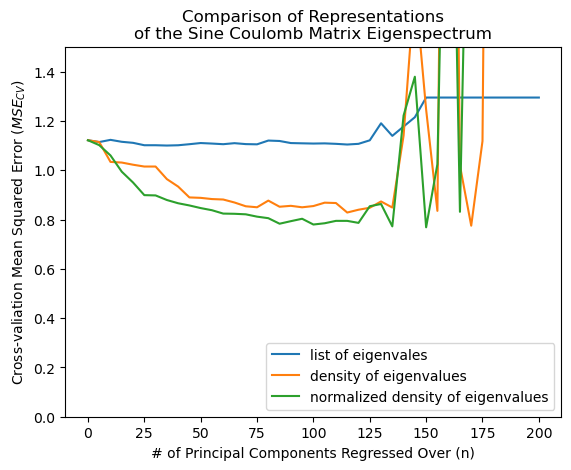

In [452]:
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['list of eigenvales', 'density of eigenvalues', 'normalized density of eigenvalues'], loc='lower right')
plt.title('Comparison of Representations\nof the Sine Coulomb Matrix Eigenspectrum')
plt.show()

The cross validation error when using the list representation of the eigenvalues is never less that of the trival model of predicting the mean band gap. Using either densisty representation yields a cross validation error that is significantly lower for small to moderate numbers of principal components regressed over ($n$), but seems to be overfitting for $n > 125$. This suggests that the density representation has more predictive power than the list represenation, at least under a model pipeline of PCA + linear regression. Of course, this analysis - all _linear_ - may be limited.

#### ... redoing the above with k-fold cross-validation

In [7]:
from sklearn.model_selection import KFold

def compare_feature_sets_PCA(df, x_cols_list, y_col, num_PCs_list, num_folds):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1111)

    # empty array to store cross validation errors, number of principal components changing across rows, feature sets across columns
    avg_cv_mse = np.empty((len(num_PCs_list)+1, len(x_cols_list)+1))
    avg_cv_mse[:] = np.nan

    # always store the error for 0 principal components, i.e. error in predicting the cv y values by the mean of the tt y values
    avg_cv_mse[0,0] = 0
    mseTotal = 0.0
    for tt_index, cv_index in kfold.split(df):
        df_tt = df.iloc[tt_index]
        df_cv = df.iloc[cv_index]
        predicted_y = np.ones(df_cv[y_col].shape) * np.mean(df_tt[y_col])
        mseTotal += mse(df_cv[y_col], predicted_y)
    avg_cv_mse[0,1:] = mseTotal / num_folds
    
    # loop over the number of principal components to use
    for (i, num_PCs) in enumerate(num_PCs_list):
        print(num_PCs)
        avg_cv_mse[i+1,0] = num_PCs
        pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=num_PCs)), ('reg', LinearRegression())])

        # ... and over feature sets
        for (j, x_cols) in enumerate(x_cols_list):

            if len(x_cols) >= num_PCs: # If there are enough features in this feature set,
                mseTotal = 0.0
                # ... loop over splits,
                for tt_index, cv_index in kfold.split(df):
                    df_tt = df.iloc[tt_index]
                    df_cv = df.iloc[cv_index]
                    pca_pipe.fit(df_tt[x_cols], df_tt[y_col]) # ... fit on tt set,
                    predicted_y = pca_pipe.predict(df_cv[x_cols]) #  ... predict on cv set,
                    mseTotal += mse(df_cv[y_col], predicted_y)
                    
                avg_cv_mse[i+1,j+1] = mseTotal / num_folds  # .. and store average cv error.
            
    return avg_cv_mse

In [7]:
cv_mses = compare_feature_sets_PCA(df_train_SSD_eigs, [eigs_columns, SSD_columns, normalized_SSD_columns], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)

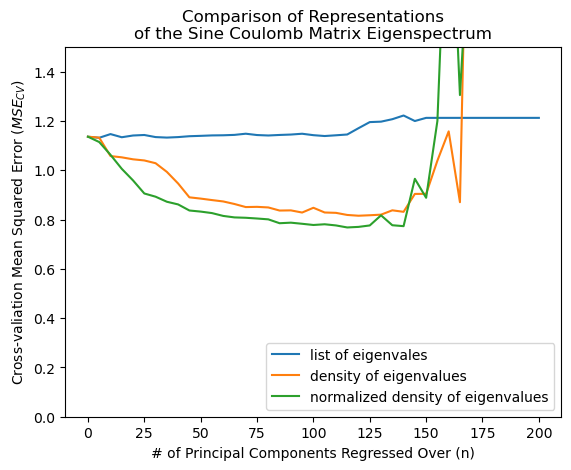

In [8]:
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['list of eigenvales', 'density of eigenvalues', 'normalized density of eigenvalues'], loc='lower right')
plt.title('Comparison of Representations\nof the Sine Coulomb Matrix Eigenspectrum')
plt.show()

#### revisiting SSD normalization, 2025-03-22 update:
Since normalizing the density improved performance, I now compare three ways to normalize the SSDs. In all cases, I normalize for each MOF jointly across the two densities (for positive and negative eigenvalues), dividing both by the same factor.

0. the normalization used in the cross-validation just above: dividing by SSDs by the number of atoms in the MOF unit cell.
1. for each MOF, divide by the sum of its SSD values. This is the discrete version of $\tilde{\mathrm{SSD}}$, discussed above. Up to discretization error and an overall factor common to all MOFs, this should be identical to the first type.
2. for each MOF, divide by the square root of the sum of squares of its SSD values. This is the discrete version of $\hat{\mathrm{SSD}}$, discussed above. 


In [8]:
# normalization type 1: unit sum across rows 
df_SSD_normalized[normalized_SSD_columns] = df_SSD_normalized[normalized_SSD_columns].div(df_SSD_normalized[normalized_SSD_columns].sum(axis=1), axis=0)

# rename columns pre-merge
df_SSD_normalized = df_SSD_normalized.rename(columns = dict(
    [
        [col + ' normalized', col + ' normalized-1']
        for col in SSD_columns
    ]
))

# add normalized-1 density values to joint data frame
df_train_SSD_eigs = df_train_SSD_eigs.merge(df_SSD_normalized)

# check for sum across rows of 1
normalized1_SSD_columns = [col + ' normalized-1' for col in SSD_columns]
df_SSD_normalized[normalized1_SSD_columns].sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8643    1.0
8644    1.0
8645    1.0
8646    1.0
8647    1.0
Length: 8648, dtype: float64

In [9]:
# normalization type 2: unit sum of squares across rows 
df_SSD_normalized[normalized1_SSD_columns] = df_SSD_normalized[normalized1_SSD_columns].div(
    np.sqrt((df_SSD_normalized[normalized1_SSD_columns]**2).sum(axis=1)),
    axis=0
)

# rename columns pre-merge
df_SSD_normalized = df_SSD_normalized.rename(columns = dict(
    [
        [col + ' normalized-1', col + ' normalized-2']
        for col in SSD_columns
    ]
))

# add normalized-1 density values to joint data frame
df_train_SSD_eigs = df_train_SSD_eigs.merge(df_SSD_normalized)

# check for sum of squares across rows of 1
normalized2_SSD_columns = [col + ' normalized-2' for col in SSD_columns]
(df_SSD_normalized[normalized2_SSD_columns] ** 2).sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8643    1.0
8644    1.0
8645    1.0
8646    1.0
8647    1.0
Length: 8648, dtype: float64

In [ ]:
cv_mses = compare_feature_sets_PCA(df_train_SSD_eigs, [normalized_SSD_columns, normalized1_SSD_columns, normalized2_SSD_columns], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)

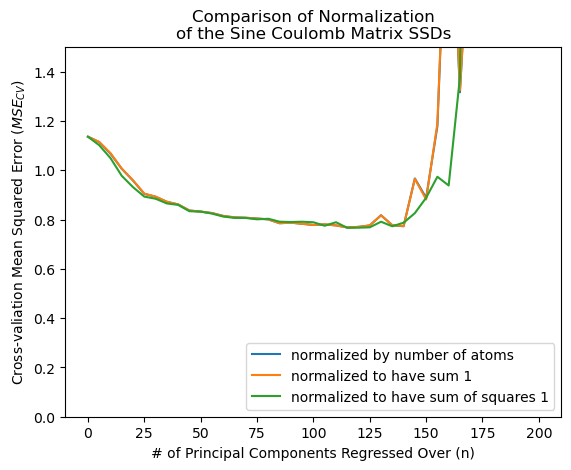

In [59]:
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['normalized by number of atoms', 'normalized to have sum 1', 'normalized to have sum of squares 1'], loc='lower right')
plt.title('Comparison of Normalization\nof the Sine Coulomb Matrix SSDs')
plt.show()

In [60]:
cv_mses

array([[  0.        ,   1.13638005,   1.13638005,   1.13638005],
       [  5.        ,   1.11471002,   1.11480306,   1.10198717],
       [ 10.        ,   1.06737312,   1.06982413,   1.04951005],
       [ 15.        ,   1.0063482 ,   1.00697219,   0.97754345],
       [ 20.        ,   0.95828575,   0.95929492,   0.93163585],
       [ 25.        ,   0.90445337,   0.90525467,   0.8933103 ],
       [ 30.        ,   0.89283684,   0.89341228,   0.88469726],
       [ 35.        ,   0.87236724,   0.8723985 ,   0.8655723 ],
       [ 40.        ,   0.86146029,   0.8617038 ,   0.85973314],
       [ 45.        ,   0.83694891,   0.83704552,   0.83399438],
       [ 50.        ,   0.8322987 ,   0.83253428,   0.8325504 ],
       [ 55.        ,   0.82657005,   0.82651949,   0.82438745],
       [ 60.        ,   0.81497069,   0.81491474,   0.81232093],
       [ 65.        ,   0.80889612,   0.80908768,   0.80701841],
       [ 70.        ,   0.8074331 ,   0.8074718 ,   0.8066233 ],
       [ 75.        ,   0

Normalization schemes 0 and 1 are indistinguishable on the scale of the plot - that is an indication that the discritization error is not affecting performance. And normalization scheme 2 is very comparable. I will proceed with normalization scheme 1: it can be done just using the unnormalized SSD values and it has a nice interpretation, namely the SSD is the probabilty distribution for finding an eigenvalue in each discrete interval.

#### PCA without scaling first?
Using the Standard Scaler gives each $x$ value an equal variance - an equal amount of variance for the principal components to explain. But there seem to be parts of the spectrum that are more important than others. Does removing the pre-scaling change the above results?

In [14]:
from sklearn.model_selection import KFold

def compare_feature_sets_PCA_noScale(df, x_cols_list, y_col, num_PCs_list, num_folds):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1111)

    # empty array to store cross validation errors, number of principal components changing across rows, feature sets across columns
    avg_cv_mse = np.empty((len(num_PCs_list)+1, len(x_cols_list)+1))
    avg_cv_mse[:] = np.nan

    # always store the error for 0 principal components, i.e. error in predicting the cv y values by the mean of the tt y values
    avg_cv_mse[0,0] = 0
    mseTotal = 0.0
    for tt_index, cv_index in kfold.split(df):
        df_tt = df.iloc[tt_index]
        df_cv = df.iloc[cv_index]
        predicted_y = np.ones(df_cv[y_col].shape) * np.mean(df_tt[y_col])
        mseTotal += mse(df_cv[y_col], predicted_y)
    avg_cv_mse[0,1:] = mseTotal / num_folds
    
    # loop over the number of principal components to use
    for (i, num_PCs) in enumerate(num_PCs_list):
        print(num_PCs)
        avg_cv_mse[i+1,0] = num_PCs
        pca_pipe = Pipeline([('pca', PCA(n_components=num_PCs)), ('reg', LinearRegression())])

        # ... and over feature sets
        for (j, x_cols) in enumerate(x_cols_list):

            if len(x_cols) >= num_PCs: # If there are enough features in this feature set,
                mseTotal = 0.0
                # ... loop over splits,
                for tt_index, cv_index in kfold.split(df):
                    df_tt = df.iloc[tt_index]
                    df_cv = df.iloc[cv_index]
                    pca_pipe.fit(df_tt[x_cols], df_tt[y_col]) # ... fit on tt set,
                    predicted_y = pca_pipe.predict(df_cv[x_cols]) #  ... predict on cv set,
                    mseTotal += mse(df_cv[y_col], predicted_y)
                    
                avg_cv_mse[i+1,j+1] = mseTotal / num_folds  # .. and store average cv error.
            
    return avg_cv_mse

In [ ]:
cv_mses = compare_feature_sets_PCA_noScale(df_train_SSD_eigs, [eigs_columns, SSD_columns, normalized_SSD_columns], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)

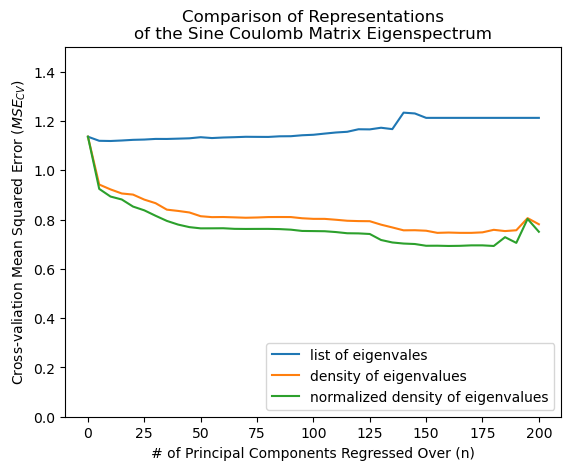

In [16]:
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['list of eigenvales', 'density of eigenvalues', 'normalized density of eigenvalues'], loc='lower right')
plt.title('Comparison of Representations\nof the Sine Coulomb Matrix Eigenspectrum')
plt.show()

In [ ]:
cv_mses = compare_feature_sets_PCA_noScale(df_train_SSD_eigs, [normalized_SSD_columns, normalized1_SSD_columns, normalized2_SSD_columns], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)

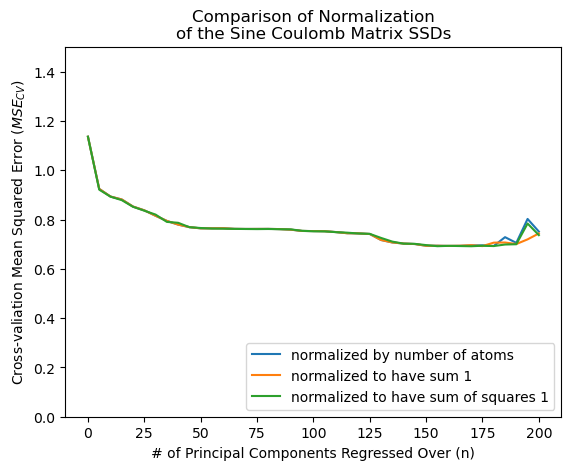

In [18]:
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['normalized by number of atoms', 'normalized to have sum 1', 'normalized to have sum of squares 1'], loc='lower right')
plt.title('Comparison of Normalization\nof the Sine Coulomb Matrix SSDs')
plt.show()

In [19]:
cv_mses

array([[  0.        ,   1.13638005,   1.13638005,   1.13638005],
       [  5.        ,   0.92463312,   0.92464008,   0.92152906],
       [ 10.        ,   0.89360173,   0.89360664,   0.89315426],
       [ 15.        ,   0.88165535,   0.88166162,   0.87899362],
       [ 20.        ,   0.85290211,   0.85290603,   0.85191818],
       [ 25.        ,   0.83759063,   0.83759785,   0.83617278],
       [ 30.        ,   0.81556794,   0.81557116,   0.82031834],
       [ 35.        ,   0.79473133,   0.7947335 ,   0.79070022],
       [ 40.        ,   0.77975401,   0.77975293,   0.78703908],
       [ 45.        ,   0.76944166,   0.76944729,   0.76925046],
       [ 50.        ,   0.76447851,   0.76447938,   0.76583489],
       [ 55.        ,   0.76459179,   0.76459367,   0.76369132],
       [ 60.        ,   0.76491101,   0.76491455,   0.76316316],
       [ 65.        ,   0.76247217,   0.76247527,   0.76224424],
       [ 70.        ,   0.76204854,   0.76205138,   0.76185471],
       [ 75.        ,   0

The conclusions don't change in comparison with the analysis with pre-scaling, but the cross-validation error seems slightly lower.